- 1972년 데이터로 하려고 했으나 메모리 부족으로 불가함
- be_me 포트폴리오 내 종목 수 5 미만인 행 나왔으나 아닌 것 같음
- 2020.01.31 ~ 2025.02.28 기간동안 총 62개의 데이터로 61개 수익률이 나와야 하는데 59, 60개 다수 존재함

In [ ]:
# 시작하기: 퍼사드 임포트
from qdl.facade import QDL
import pandas as pd
import numpy as np
from qdl import validator

In [2]:
q = QDL()
# 팩터 리스트 정의
factors = ["market_equity", "be_me", "ope_be", "at_gr1", "ret_12_1", "ret_1_0"]

wide_market_equity = q.load_char(
    country="usa",
    vintage="2020-",
    char="market_equity",
    date_col="eom")

# 루프 돌면서 wide DataFrame 생성
for factor in factors:
    globals()[f"wide_{factor}"] = q.load_char(
        country="usa",
        vintage="2020-",
        char=factor,
        date_col="eom"
    )

# 확인 (각 DataFrame shape 출력)
for factor in factors:
    df = globals()[f"wide_{factor}"]
    print(f"wide_{factor}: {df.shape}")

wide_market_equity: (62, 12123)
wide_be_me: (62, 12123)
wide_ope_be: (62, 12123)
wide_at_gr1: (62, 12123)
wide_ret_12_1: (62, 12123)
wide_ret_1_0: (62, 12123)


In [3]:
# 특성(Chars) 데이터셋 (와이드): size_grp
wide_size_grp = q.load_char(
    country="usa",
    vintage="2020-",
    char="size_grp",
    date_col = "eom")

# 특성(Chars) 데이터셋 (와이드): 초과수익률 
wide_ret_exc = q.load_char(
    country="usa",
    vintage="2020-",
    char="ret_exc",
    date_col="eom")


In [4]:
# 결과 저장용 딕셔너리
top_portfolios = {}
middle_portfolios = {}
bottom_portfolios = {}

for factor in factors:
    print(f"=== {factor} 포트폴리오 분류 시작 ===")
    
    # 1. non-micro 마스크
    non_micro_mask = ~wide_size_grp.isin(["micro", "nano"])
    
    # 2. non-micro 데이터만 추출
    wide_df = globals()[f"wide_{factor}"]
    wide_non_micro = wide_df.where(non_micro_mask)
    
    # 3. cross-sectional rank (non-micro 기준)
    xs_rank = wide_non_micro.rank(axis=1, method="min", pct=True)
    
    high_mask = xs_rank >= 0.666
    low_mask  = xs_rank <= 0.333
    
    non_micro_top    = xs_rank.where(high_mask)
    non_micro_bottom = xs_rank.where(low_mask)
    non_micro_middle = xs_rank.where(~high_mask & ~low_mask)
    
    # 4. 분위수 cutoff (non-micro만 기준)
    q_low  = wide_non_micro.quantile(0.333, axis=1)
    q_high = wide_non_micro.quantile(0.666, axis=1)
    
    # 5. micro 데이터만 추출
    micro_mask = wide_size_grp.isin(["micro", "nano"])
    wide_micro = wide_df.where(micro_mask)
    
    # 6. micro 포트폴리오 분류 (non-micro cutoff 기준 사용)
    micro_top    = wide_micro.where(wide_micro.ge(q_high, axis=0))
    micro_bottom = wide_micro.where(wide_micro.le(q_low, axis=0))
    micro_middle = wide_micro.where(
        (wide_micro.gt(q_low, axis=0)) & (wide_micro.lt(q_high, axis=0))
    )
    
    # 7. non-micro + micro 합치기 (최종 포트폴리오)
    top_portfolios[factor]    = non_micro_top.combine_first(micro_top)
    middle_portfolios[factor] = non_micro_middle.combine_first(micro_middle)
    bottom_portfolios[factor] = non_micro_bottom.combine_first(micro_bottom)
    
    print(f"=== {factor} 완료 ===\n")


=== market_equity 포트폴리오 분류 시작 ===
=== market_equity 완료 ===

=== be_me 포트폴리오 분류 시작 ===
=== be_me 완료 ===

=== ope_be 포트폴리오 분류 시작 ===
=== ope_be 완료 ===

=== at_gr1 포트폴리오 분류 시작 ===
=== at_gr1 완료 ===

=== ret_12_1 포트폴리오 분류 시작 ===
=== ret_12_1 완료 ===

=== ret_1_0 포트폴리오 분류 시작 ===
=== ret_1_0 완료 ===



In [5]:
# 날짜별로 포트폴리오에 포함된 주식 수 카운트

# 수정된 포트폴리오 저장 dict
filtered_top_portfolios = {}
filtered_middle_portfolios = {}
filtered_bottom_portfolios = {}

for factor in factors:
    print(f"=== {factor.upper()} 포트폴리오 필터링 ===")
    
    # 원래 포트폴리오 불러오기
    top_df    = top_portfolios[factor]
    middle_df = middle_portfolios[factor]
    bottom_df = bottom_portfolios[factor]
    
    # 날짜별 종목 수
    top_count    = top_df.notna().sum(axis=1)
    middle_count = middle_df.notna().sum(axis=1)
    bottom_count = bottom_df.notna().sum(axis=1)
    
    # 5개 미만인 날짜 찾기
    invalid_dates = (top_count < 5) | (middle_count < 5) | (bottom_count < 5)
    
    if invalid_dates.any():
        print(f"{factor}: ⚠️ {invalid_dates.sum()} 개 월 제외")
        
        # 해당 월 전체를 NaN 처리 (top/middle/bottom 모두 제외)
        top_df.loc[invalid_dates, :]    = float("nan")
        middle_df.loc[invalid_dates, :] = float("nan")
        bottom_df.loc[invalid_dates, :] = float("nan")
    else:
        print(f"{factor}: ✅ 모든 월에서 5개 이상 유지")
    
    # 필터링된 결과 저장
    filtered_top_portfolios[factor]    = top_df
    filtered_middle_portfolios[factor] = middle_df
    filtered_bottom_portfolios[factor] = bottom_df

    # 제외된 월의 날짜와 포트폴리오 종목 수 출력
for factor in factors:
    print(f"\n=== {factor.upper()} 제외된 월 상세 ===")
    
    # 원래 포트폴리오 불러오기
    top_df    = top_portfolios[factor]
    middle_df = middle_portfolios[factor]
    bottom_df = bottom_portfolios[factor]
    
    # 날짜별 종목 수
    top_count    = top_df.notna().sum(axis=1)
    middle_count = middle_df.notna().sum(axis=1)
    bottom_count = bottom_df.notna().sum(axis=1)
    
    # 5개 미만인 날짜
    invalid_dates = (top_count < 5) | (middle_count < 5) | (bottom_count < 5)
    
    if invalid_dates.any():
        invalid_info = pd.DataFrame({
            "Top_count": top_count[invalid_dates],
            "Middle_count": middle_count[invalid_dates],
            "Bottom_count": bottom_count[invalid_dates],
        })
        print(invalid_info)
    else:
        print("✅ 제외된 월 없음")


=== MARKET_EQUITY 포트폴리오 필터링 ===
market_equity: ✅ 모든 월에서 5개 이상 유지
=== BE_ME 포트폴리오 필터링 ===
be_me: ⚠️ 1 개 월 제외
=== OPE_BE 포트폴리오 필터링 ===
ope_be: ✅ 모든 월에서 5개 이상 유지
=== AT_GR1 포트폴리오 필터링 ===
at_gr1: ✅ 모든 월에서 5개 이상 유지
=== RET_12_1 포트폴리오 필터링 ===
ret_12_1: ✅ 모든 월에서 5개 이상 유지
=== RET_1_0 포트폴리오 필터링 ===
ret_1_0: ✅ 모든 월에서 5개 이상 유지

=== MARKET_EQUITY 제외된 월 상세 ===
✅ 제외된 월 없음

=== BE_ME 제외된 월 상세 ===
            Top_count  Middle_count  Bottom_count
eom                                              
2025-02-28          0             0             0

=== OPE_BE 제외된 월 상세 ===
✅ 제외된 월 없음

=== AT_GR1 제외된 월 상세 ===
✅ 제외된 월 없음

=== RET_12_1 제외된 월 상세 ===
✅ 제외된 월 없음

=== RET_1_0 제외된 월 상세 ===
✅ 제외된 월 없음


In [6]:
# 마스크 저장용 dict
top_masks = {}
middle_masks = {}
bottom_masks = {}

for factor in factors:
    print(f"=== {factor.upper()} 마스크 생성 ===")
    
    # 최종 포트폴리오 불러오기 (필터링된 버전 쓰셔도 됨)
    top_df    = filtered_top_portfolios[factor]
    middle_df = filtered_middle_portfolios[factor]
    bottom_df = filtered_bottom_portfolios[factor]
    
    # notna() → 불리언 마스크 생성
    top_masks[factor]    = top_df.notna()
    middle_masks[factor] = middle_df.notna()
    bottom_masks[factor] = bottom_df.notna()

=== MARKET_EQUITY 마스크 생성 ===
=== BE_ME 마스크 생성 ===
=== OPE_BE 마스크 생성 ===
=== AT_GR1 마스크 생성 ===
=== RET_12_1 마스크 생성 ===
=== RET_1_0 마스크 생성 ===


EW

In [7]:
# Top=Short 인 팩터들
top_as_short = ["market_equity", "at_gr1", "ret_1_0"]

# 결과 저장 dict
short_ports = {}
long_ports = {}

for factor in factors:
    print(f"=== {factor.upper()} 롱/숏 포트폴리오 계산 ===")
    
    top_mask    = top_masks[factor].shift(1)     # forward-looking 방지
    bottom_mask = bottom_masks[factor].shift(1)
    
    if factor in top_as_short:
        # Top = Short, Bottom = Long
        short_ports[factor] = -1 * wide_ret_exc.where(top_mask)
        long_ports[factor]  =      wide_ret_exc.where(bottom_mask)
    else:
        # Top = Long, Bottom = Short
        short_ports[factor] = -1 * wide_ret_exc.where(bottom_mask)
        long_ports[factor]  =      wide_ret_exc.where(top_mask)

=== MARKET_EQUITY 롱/숏 포트폴리오 계산 ===
=== BE_ME 롱/숏 포트폴리오 계산 ===
=== OPE_BE 롱/숏 포트폴리오 계산 ===
=== AT_GR1 롱/숏 포트폴리오 계산 ===
=== RET_12_1 롱/숏 포트폴리오 계산 ===
=== RET_1_0 롱/숏 포트폴리오 계산 ===


=== MARKET_EQUITY EW 팩터 수익률 계산 ===
=== BE_ME EW 팩터 수익률 계산 ===
=== OPE_BE EW 팩터 수익률 계산 ===
=== AT_GR1 EW 팩터 수익률 계산 ===
=== RET_12_1 EW 팩터 수익률 계산 ===
=== RET_1_0 EW 팩터 수익률 계산 ===


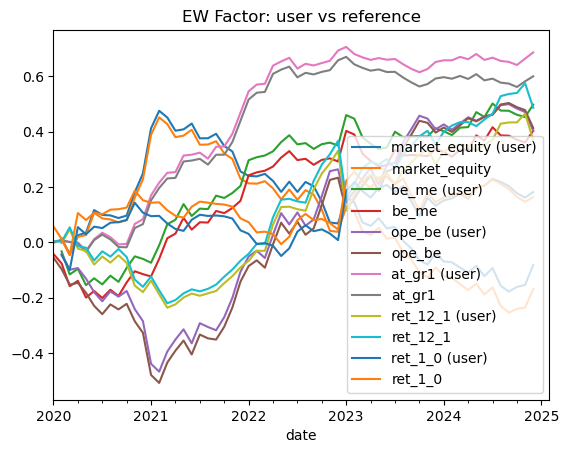

In [8]:
# 결과 저장 dict
factor_returns_ew = {}
factor_answers_ew = {}

for factor in factors:
    print(f"=== {factor.upper()} EW 팩터 수익률 계산 ===")
    
    # 1. 직접 계산 (short/long은 앞에서 만든 dict 사용)
    short_port = short_ports[factor]
    long_port  = long_ports[factor]
    
    short_ret = short_port.mean(axis=1)
    long_ret  = long_port.mean(axis=1)
    
    factor_ret_ew = short_ret + long_ret   # factor = short + long
    factor_returns_ew[factor] = factor_ret_ew
    
    # 2. reference 불러오기
    factor_answer = q.load_factors(
        country="usa",
        dataset="factor",
        weighting="ew",
        factors=[factor],
    )
    factor_answers_ew[factor] = factor_answer
    
    # 3. 그래프 비교
    ax = factor_ret_ew.cumsum().plot(label=f"{factor} (user)")
    factor_answer.loc["2020-01-31":, :].cumsum().plot(ax=ax, label=f"{factor} (ref)")
    ax.set_title("EW Factor: user vs reference")
    ax.legend()


=== MARKET_EQUITY EW Factor 검증 ===
[DEBUG] user_factor: 59개 (2020-02-29 00:00:00 ~ 2024-12-31 00:00:00)
[DEBUG] ref_factor : 1188개 (1926-01-31 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 59 시작일: 2020-02-29 00:00:00 종료일: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.002 mae: 0.002 corr: 0.999

=== BE_ME EW Factor 검증 ===
[DEBUG] user_factor: 59개 (2020-02-29 00:00:00 ~ 2024-12-31 00:00:00)
[DEBUG] ref_factor : 890개 (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 59 시작일: 2020-02-29 00:00:00 종료일: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.002 mae: 0.001 corr: 0.999

=== OPE_BE EW Factor 검증 ===
[DEBUG] user_factor: 59개 (2020-02-29 00:00:00 ~ 2024-12-31 00:00:00)
[DEBUG] ref_factor : 890개 (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 59 시작일: 2020-02-29 00:00:00 종료일: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.002 mae: 0.001 corr: 1.000

=== AT_GR1 EW Factor 검증 ===
[DEBUG] user_factor: 59개 (2020-02-29 00:00:00 ~ 2024-12-31 00:00:00)
[DEBUG] ref_factor : 878개 (1951-11-30 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 

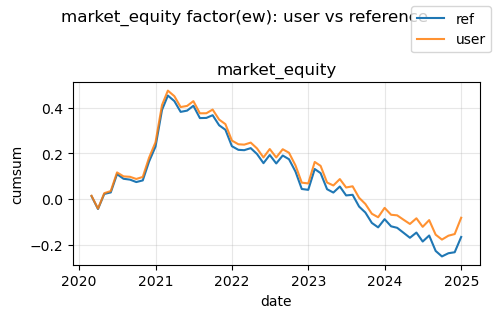

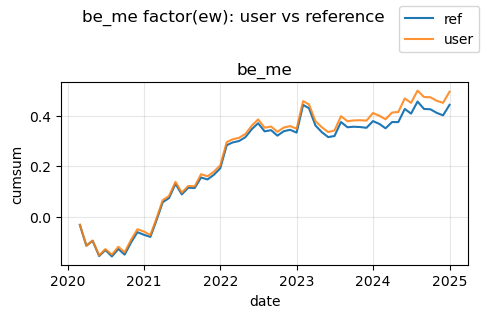

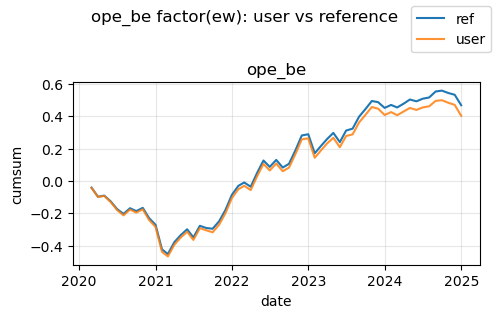

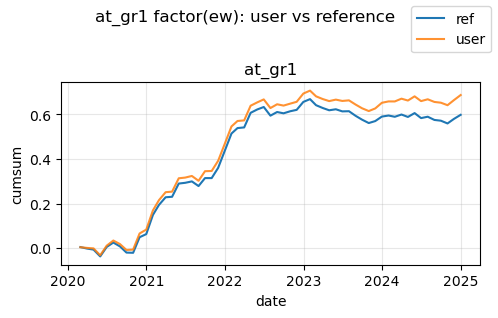

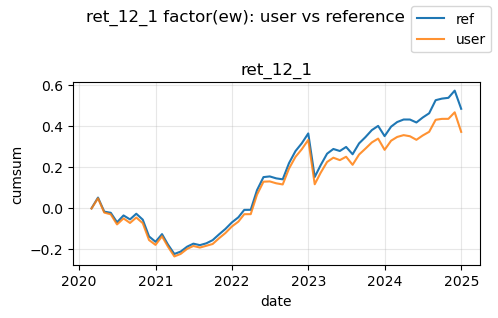

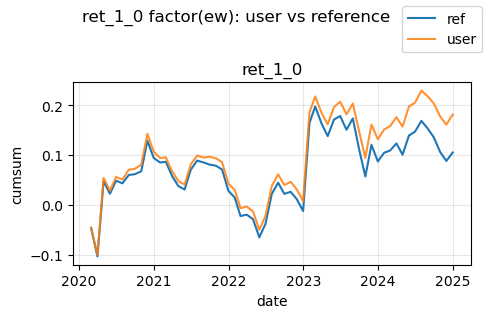

In [9]:
# 결과 저장 dict
validation_reports = {}

def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

for factor in factors:
    print(f"\n=== {factor.upper()} EW Factor 검증 ===")
    
    # 1. user factor (Series → DataFrame)
    user_factor = pd.DataFrame(factor_returns_ew[factor])
    user_factor.columns = [factor]
    
    # 2. reference factor
    ref_factor = factor_answers_ew[factor]
    
    # 🔎 길이 및 날짜 범위 체크
    print(f"[DEBUG] user_factor: {user_factor.dropna().shape[0]}개 "
          f"({user_factor.dropna().index.min()} ~ {user_factor.dropna().index.max()})")
    print(f"[DEBUG] ref_factor : {ref_factor.dropna().shape[0]}개 "
          f"({ref_factor.dropna().index.min()} ~ {ref_factor.dropna().index.max()})")
    
    # 3. validator 실행
    report = validator.validate_factor(
        user=user_factor,
        reference=ref_factor,
        return_plot=True,
        plot_title=f"{factor} factor(ew): user vs reference",
    )
    
    # 4. 결과 출력
    print("관측치수:", report.n_obs, 
          "시작일:", report.date_start, 
          "종료일:", report.date_end)
    print(
        "mse:", _fmt(report.mse),
        "rmse:", _fmt(report.rmse),
        "mae:", _fmt(report.mae),
        "corr:", _fmt(report.corr),
    )
    
    # 5. dict에 저장
    validation_reports[factor] = report


VW

=== MARKET_EQUITY VW 가중치 계산 ===
=== BE_ME VW 가중치 계산 ===
=== OPE_BE VW 가중치 계산 ===
=== AT_GR1 VW 가중치 계산 ===
=== RET_12_1 VW 가중치 계산 ===
=== RET_1_0 VW 가중치 계산 ===
=== MARKET_EQUITY VW 수익률 계산 ===
=== BE_ME VW 수익률 계산 ===
=== OPE_BE VW 수익률 계산 ===
=== AT_GR1 VW 수익률 계산 ===
=== RET_12_1 VW 수익률 계산 ===
=== RET_1_0 VW 수익률 계산 ===
=== MARKET_EQUITY VW 팩터 수익률 계산 ===
=== BE_ME VW 팩터 수익률 계산 ===
=== OPE_BE VW 팩터 수익률 계산 ===
=== AT_GR1 VW 팩터 수익률 계산 ===
=== RET_12_1 VW 팩터 수익률 계산 ===
=== RET_1_0 VW 팩터 수익률 계산 ===


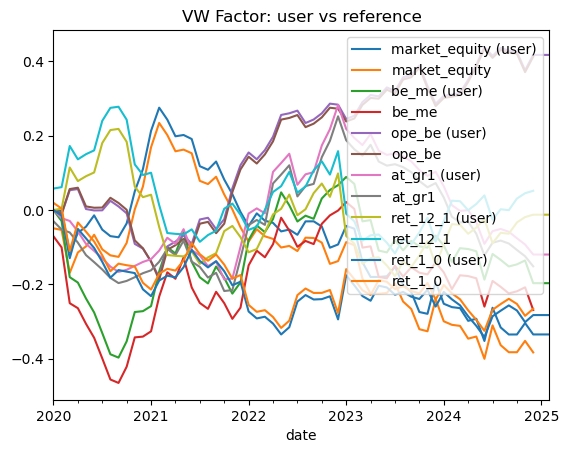

In [10]:
# Top=Short 인 팩터들
top_as_short = ["market_equity", "at_gr1", "ret_1_0"]

# === 결과 저장 dict ===
short_ports_vw = {}
long_ports_vw = {}

# === VW 가중치 계산 함수 ===
def get_portfolio_vw_weights(me_df, mask_shifted):
    """
    me_df         : wide_{factor} (factor별 와이드 ME 데이터)
    mask_shifted  : t-1 시점 포트폴리오 마스크
    """
    port_me = me_df.where(mask_shifted)                 # 포트 ME만 남김
    return port_me.div(port_me.sum(axis=1), axis=0)     # Σ포트 ME로 나눠서 정규화


# === 결과 저장 dict ===
top_weights_vw = {}
middle_weights_vw = {}
bottom_weights_vw = {}

for factor in factors:
    print(f"=== {factor.upper()} VW 가중치 계산 ===")
    
    # (1) wide_{factor} ME 데이터 불러오기
    me_df = wide_market_equity
    
    # (2) 포트폴리오 마스크 (t-1 기준 shift)
    top_mask_shifted    = top_masks[factor].shift(1)
    middle_mask_shifted = middle_masks[factor].shift(1)
    bottom_mask_shifted = bottom_masks[factor].shift(1)
    
    # (3) VW 가중치 계산
    top_weights_vw[factor]    = get_portfolio_vw_weights(me_df.shift(1), top_mask_shifted)
    middle_weights_vw[factor] = get_portfolio_vw_weights(me_df.shift(1), middle_mask_shifted)
    bottom_weights_vw[factor] = get_portfolio_vw_weights(me_df.shift(1), bottom_mask_shifted)

# === 포트폴리오별 VW 수익률 계산 함수 ===
def get_portfolio_vw_return(ret_df, weights):
    return (ret_df * weights).sum(axis=1)   # 종목별 ret × weight 합


# === 결과 저장 dict ===
top_rets_vw = {}
middle_rets_vw = {}
bottom_rets_vw = {}

for factor in factors:
    print(f"=== {factor.upper()} VW 수익률 계산 ===")
    
    # (1) 포트폴리오별 가중치 불러오기
    top_w    = top_weights_vw[factor]
    middle_w = middle_weights_vw[factor]
    bottom_w = bottom_weights_vw[factor]
    
    # (2) 수익률 계산 (ret_exc × weight)
    top_rets_vw[factor]    = get_portfolio_vw_return(wide_ret_exc, top_w)
    middle_rets_vw[factor] = get_portfolio_vw_return(wide_ret_exc, middle_w)
    bottom_rets_vw[factor] = get_portfolio_vw_return(wide_ret_exc, bottom_w)

    # 결과 저장 dict
factor_returns_vw = {}
factor_answers_vw = {}

for factor in factors:
    print(f"=== {factor.upper()} VW 팩터 수익률 계산 ===")
    
    # (1) 포트폴리오 수익률 불러오기
    top_ret    = top_rets_vw[factor]
    bottom_ret = bottom_rets_vw[factor]
    
    # (2) 팩터 방향 결정 (Top=Short 여부)
    if factor in ["market_equity", "at_gr1", "ret_1_0"]:
        factor_ret_vw = bottom_ret - top_ret   # 높은 값 short
    else:
        factor_ret_vw = top_ret - bottom_ret   # 낮은 값 short
    
    # (3) 저장
    factor_returns_vw[factor] = factor_ret_vw
    
    # (4) reference factor 불러오기
    factor_answer = q.load_factors(
        country="usa",
        dataset="factor",
        weighting="vw",
        factors=[factor],
    )
    factor_answers_vw[factor] = factor_answer
    
    # (5) 그래프 비교
    ax = factor_ret_vw.cumsum().plot(label=f"{factor} (user)")
    factor_answer.loc["2020-01-31":, :].cumsum().plot(ax=ax, label=f"{factor} (ref)")
    ax.set_title("VW Factor: user vs reference")
    ax.legend()




=== MARKET_EQUITY VW Factor 검증 ===
[DEBUG] user_factor: 62개 (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 1188개 (1926-01-31 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 60 시작일: 2020-01-31 00:00:00 종료일: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.006 mae: 0.002 corr: 0.990

=== BE_ME VW Factor 검증 ===
[DEBUG] user_factor: 62개 (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 890개 (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 60 시작일: 2020-01-31 00:00:00 종료일: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.009 mae: 0.001 corr: 0.983

=== OPE_BE VW Factor 검증 ===
[DEBUG] user_factor: 62개 (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 890개 (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 60 시작일: 2020-01-31 00:00:00 종료일: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.002 mae: 0.001 corr: 0.999

=== AT_GR1 VW Factor 검증 ===
[DEBUG] user_factor: 62개 (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 878개 (1951-11-30 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 

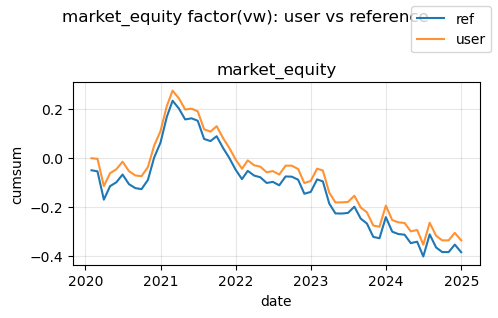

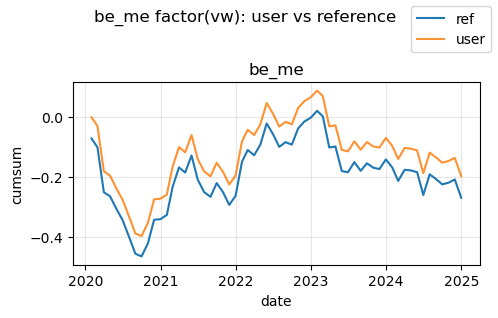

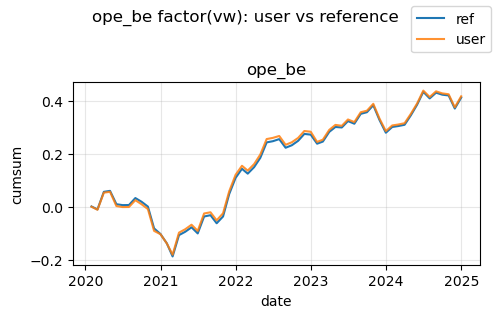

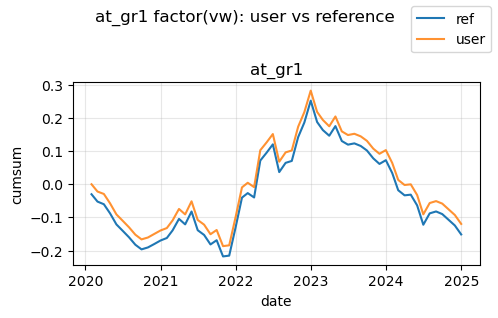

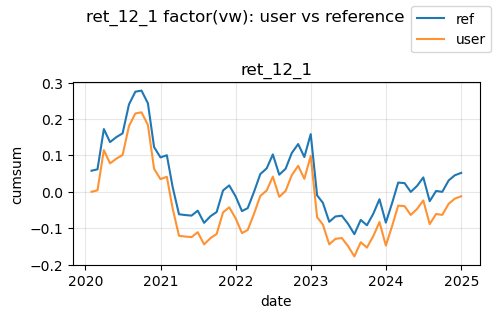

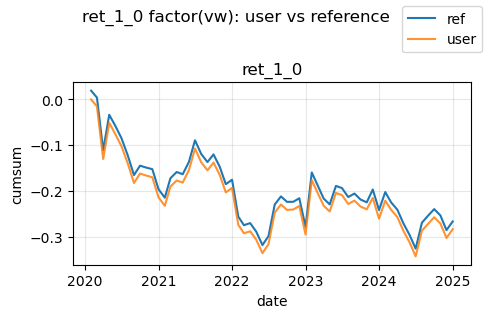

In [11]:
# 결과 저장 dict
validation_reports = {}

def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

for factor in factors:
    print(f"\n=== {factor.upper()} VW Factor 검증 ===")
    
    # 1. user factor (Series → DataFrame)
    user_factor = pd.DataFrame(factor_returns_vw[factor])
    user_factor.columns = [factor]
    
    # 2. reference factor
    ref_factor = factor_answers_vw[factor]
    
    # 🔎 길이 및 날짜 범위 체크
    print(f"[DEBUG] user_factor: {user_factor.dropna().shape[0]}개 "
          f"({user_factor.dropna().index.min()} ~ {user_factor.dropna().index.max()})")
    print(f"[DEBUG] ref_factor : {ref_factor.dropna().shape[0]}개 "
          f"({ref_factor.dropna().index.min()} ~ {ref_factor.dropna().index.max()})")
    
    # 3. validator 실행
    report = validator.validate_factor(
        user=user_factor,
        reference=ref_factor,
        return_plot=True,
        plot_title=f"{factor} factor(vw): user vs reference",
    )
    
    # 4. 결과 출력
    print("관측치수:", report.n_obs, 
          "시작일:", report.date_start, 
          "종료일:", report.date_end)
    print(
        "mse:", _fmt(report.mse),
        "rmse:", _fmt(report.rmse),
        "mae:", _fmt(report.mae),
        "corr:", _fmt(report.corr),
    )
    
    # 5. dict에 저장
    validation_reports[factor] = report


VW_CAP

=== MARKET_EQUITY VW 가중치 계산 ===
=== BE_ME VW 가중치 계산 ===
=== OPE_BE VW 가중치 계산 ===
=== AT_GR1 VW 가중치 계산 ===
=== RET_12_1 VW 가중치 계산 ===
=== RET_1_0 VW 가중치 계산 ===
=== MARKET_EQUITY VW 수익률 계산 ===
=== BE_ME VW 수익률 계산 ===
=== OPE_BE VW 수익률 계산 ===
=== AT_GR1 VW 수익률 계산 ===
=== RET_12_1 VW 수익률 계산 ===
=== RET_1_0 VW 수익률 계산 ===
=== MARKET_EQUITY VW_CAP 팩터 수익률 계산 ===
=== BE_ME VW_CAP 팩터 수익률 계산 ===
=== OPE_BE VW_CAP 팩터 수익률 계산 ===
=== AT_GR1 VW_CAP 팩터 수익률 계산 ===
=== RET_12_1 VW_CAP 팩터 수익률 계산 ===
=== RET_1_0 VW_CAP 팩터 수익률 계산 ===


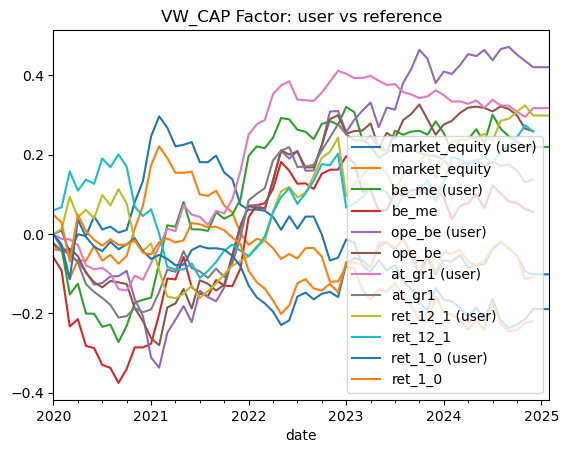

In [12]:
# Top=Short 인 팩터들
top_as_short = ["market_equity", "at_gr1", "ret_1_0"]

# === 결과 저장 dict ===
short_ports_vw = {}
long_ports_vw = {}

# === Capped VW_CAP 가중치 계산 함수 ===
# === Capped VW_CAP 가중치 계산 함수 ===
def get_portfolio_vw_cap_weights(me_df, mask_shifted):
    """
    me_df        : wide_{factor} (전체 종목 ME, t-1 기준)
    mask_shifted : t-1 시점 포트폴리오 마스크
    -------------------------------------------------------
    로직:
    1) 전체 universe에서 VW weight 계산
    2) 각 시점별 80th percentile weight (cap threshold) 계산
    3) 포트폴리오 종목들의 weight에 cap 적용
    4) normalize 해서 합 = 1
    """
    
    # 1. 전체 universe의 VW weight (각 시점 합=1)
    all_weights = me_df.div(me_df.sum(axis=1), axis=0)

    # 2. 각 시점별 80th percentile 계산 (NYSE 80th percentile weight)
    cap_threshold = all_weights.quantile(0.8, axis=1)   # row별 scalar 값

    # 3. 포트 ME만 추출
    port_me = me_df.where(mask_shifted)

    # 4. 포트 내부 VW weight
    weights = port_me.div(port_me.sum(axis=1), axis=0)

    # 5. cap 적용: 각 시점별 cap_threshold를 비교해서 초과하는 weight는 잘라줌
    capped = weights.apply(lambda row: np.minimum(row, cap_threshold[row.name]), axis=1)

    # 6. 다시 normalize (합=1)
    capped_norm = capped.div(capped.sum(axis=1), axis=0)

    return capped_norm


# === 결과 저장 dict ===
top_weights_vw_cap = {}
middle_weights_vw_cap = {}
bottom_weights_vw_cap = {}

for factor in factors:
    print(f"=== {factor.upper()} VW 가중치 계산 ===")
    
    # (1) wide_{factor} ME 데이터 불러오기
    me_df = wide_market_equity
    
    # (2) 포트폴리오 마스크 (t-1 기준 shift)
    top_mask_shifted    = top_masks[factor].shift(1)
    middle_mask_shifted = middle_masks[factor].shift(1)
    bottom_mask_shifted = bottom_masks[factor].shift(1)
    
    # (3) VW 가중치 계산
    top_weights_vw_cap[factor]    = get_portfolio_vw_cap_weights(me_df.shift(1), top_mask_shifted)
    middle_weights_vw_cap[factor] = get_portfolio_vw_cap_weights(me_df.shift(1), middle_mask_shifted)
    bottom_weights_vw_cap[factor] = get_portfolio_vw_cap_weights(me_df.shift(1), bottom_mask_shifted)

# === 포트폴리오별 VW 수익률 계산 함수 ===
def get_portfolio_vw_cap_return(ret_df, weights):
    return (ret_df * weights).sum(axis=1)   # 종목별 ret × weight 합

# === 결과 저장 dict ===
top_rets_vw_cap = {}
middle_rets_vw_cap = {}
bottom_rets_vw_cap = {}

for factor in factors:
    print(f"=== {factor.upper()} VW 수익률 계산 ===")
    
    # (1) 포트폴리오별 가중치 불러오기
    top_w    = top_weights_vw_cap[factor]
    middle_w = middle_weights_vw_cap[factor]
    bottom_w = bottom_weights_vw_cap[factor]
    
    # (2) 수익률 계산 (ret_exc × weight)
    top_rets_vw_cap[factor]    = get_portfolio_vw_cap_return(wide_ret_exc, top_w)
    middle_rets_vw_cap[factor] = get_portfolio_vw_cap_return(wide_ret_exc, middle_w)
    bottom_rets_vw_cap[factor] = get_portfolio_vw_cap_return(wide_ret_exc, bottom_w)

    # 결과 저장 dict
factor_returns_vw_cap = {}
factor_answers_vw_cap = {}

for factor in factors:
    print(f"=== {factor.upper()} VW_CAP 팩터 수익률 계산 ===")
    
    # (1) 포트폴리오 수익률 불러오기
    top_ret    = top_rets_vw_cap[factor]
    bottom_ret = bottom_rets_vw_cap[factor]
    
    # (2) 팩터 방향 결정 (Top=Short 여부)
    if factor in ["market_equity", "at_gr1", "ret_1_0"]:
        factor_ret_vw_cap = bottom_ret - top_ret   # 높은 값 short
    else:
        factor_ret_vw_cap = top_ret - bottom_ret   # 낮은 값 short
    
    # (3) 저장
    factor_returns_vw_cap[factor] = factor_ret_vw_cap
    
    # (4) reference factor 불러오기
    factor_answer = q.load_factors(
        country="usa",
        dataset="factor",
        weighting="vw_cap",
        factors=[factor],
    )
    factor_answers_vw_cap[factor] = factor_answer
    
    # (5) 그래프 비교
    ax = factor_ret_vw_cap.cumsum().plot(label=f"{factor} (user)")
    factor_answer.loc["2020-01-31":, :].cumsum().plot(ax=ax, label=f"{factor} (ref)")
    ax.set_title("VW_CAP Factor: user vs reference")
    ax.legend()




=== MARKET_EQUITY VW_cap Factor 검증 ===
[DEBUG] user_factor: 62개 (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 1188개 (1926-01-31 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 60 시작일: 2020-01-31 00:00:00 종료일: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.010 mae: 0.008 corr: 0.958

=== BE_ME VW_cap Factor 검증 ===
[DEBUG] user_factor: 62개 (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 890개 (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 60 시작일: 2020-01-31 00:00:00 종료일: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.012 mae: 0.009 corr: 0.961

=== OPE_BE VW_cap Factor 검증 ===
[DEBUG] user_factor: 62개 (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 890개 (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
관측치수: 60 시작일: 2020-01-31 00:00:00 종료일: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.015 mae: 0.012 corr: 0.936

=== AT_GR1 VW_cap Factor 검증 ===
[DEBUG] user_factor: 62개 (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 878개 (1951-11-30 00:00:00 ~ 2024-12-31 

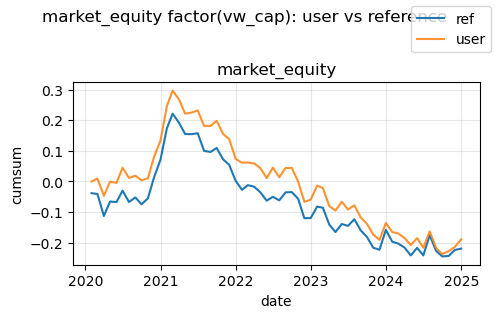

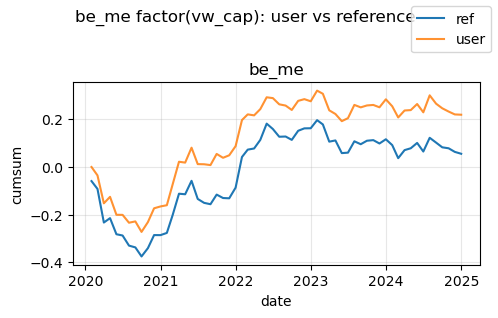

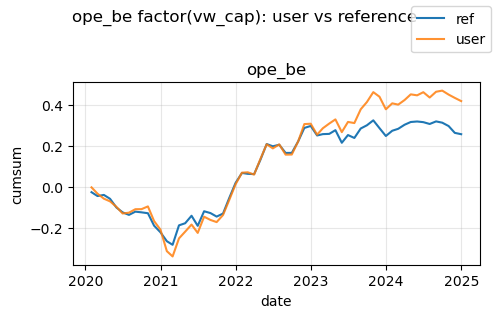

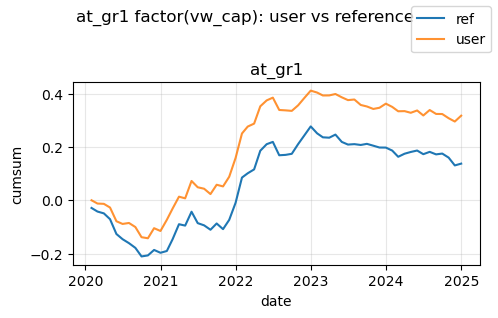

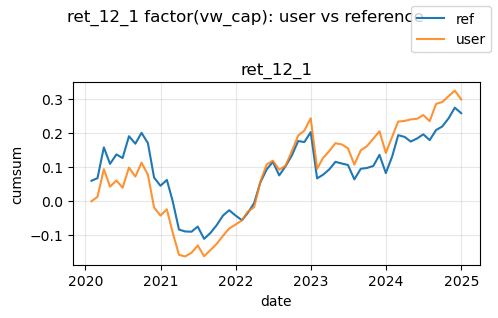

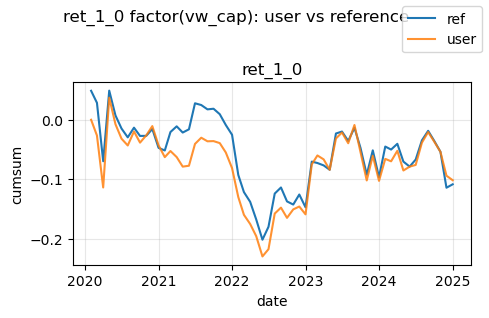

In [13]:
# 결과 저장 dict
validation_reports = {}

def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

for factor in factors:
    print(f"\n=== {factor.upper()} VW_cap Factor 검증 ===")
    
    # 1. user factor (Series → DataFrame)
    user_factor = pd.DataFrame(factor_returns_vw_cap[factor])
    user_factor.columns = [factor]
    
    # 2. reference factor
    ref_factor = factor_answers_vw_cap[factor]
    
    # 🔎 길이 및 날짜 범위 체크
    print(f"[DEBUG] user_factor: {user_factor.dropna().shape[0]}개 "
          f"({user_factor.dropna().index.min()} ~ {user_factor.dropna().index.max()})")
    print(f"[DEBUG] ref_factor : {ref_factor.dropna().shape[0]}개 "
          f"({ref_factor.dropna().index.min()} ~ {ref_factor.dropna().index.max()})")
    
    # 3. validator 실행
    report = validator.validate_factor(
        user=user_factor,
        reference=ref_factor,
        return_plot=True,
        plot_title=f"{factor} factor(vw_cap): user vs reference",
    )
    
    # 4. 결과 출력
    print("관측치수:", report.n_obs, 
          "시작일:", report.date_start, 
          "종료일:", report.date_end)
    print(
        "mse:", _fmt(report.mse),
        "rmse:", _fmt(report.rmse),
        "mae:", _fmt(report.mae),
        "corr:", _fmt(report.corr),
    )
    
    # 5. dict에 저장
    validation_reports[factor] = report
